<a href="https://colab.research.google.com/github/galacticor/learndatascience/blob/master/mlforbattery/MLforbattery1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [96]:
data = pd.read_csv("https://raw.githubusercontent.com/galacticor/learndatascience/master/mlforbattery/preproccess.xlsx%20-%20Test1.csv")

  Cycle discharge  discharge_b  diameter
0     2  277.3889     177.8056      12.0
1     3  317.3194     277.3889      12.0
2     4  354.3333     317.3194      12.0
3     5  368.6806     354.3333      12.0
4     6  369.0556     368.6806      12.0


(654, 4)

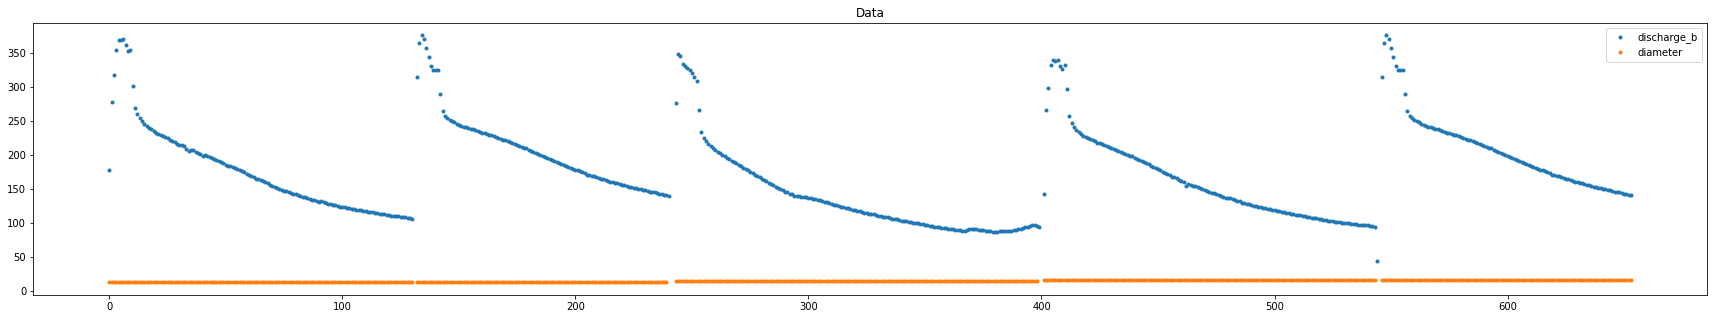

In [97]:
# data = data.drop(labels=['Cycle'], axis=1)
y = data.discharge
print(data.head())
_ = data.plot(style='.', figsize=(30,5), title='Data')
data.describe()
data.shape

In [115]:
data = data.dropna()
data.rename(columns={'discharge' : 'target'}, inplace=True)
print(data.head())
data['target'] = data['target'].astype(float)
data['Cycle'] = data['Cycle'].astype(int)
data['diameter'] = data['diameter'].astype(int)
data.dtypes

   Cycle    target  discharge_b  diameter
0      2  277.3889     177.8056        12
1      3  317.3194     277.3889        12
2      4  354.3333     317.3194        12
3      5  368.6806     354.3333        12
4      6  369.0556     368.6806        12


Cycle            int64
target         float64
discharge_b    float64
diameter         int64
dtype: object

In [116]:
data_train = data.loc[data.diameter < 16].copy()
data_test = data.loc[data.diameter >= 16].copy()
y_train = data_train.target
y_test = data_test.target
data_test.drop(labels=['target'], axis=1, inplace=True)
data_train.drop(labels=['target'], axis=1, inplace=True)
data_train.head()
print(data)

     Cycle    target  discharge_b  diameter
0        2  277.3889     177.8056        12
1        3  317.3194     277.3889        12
2        4  354.3333     317.3194        12
3        5  368.6806     354.3333        12
4        6  369.0556     368.6806        12
..     ...       ...          ...       ...
649    105  142.9167     143.6667        16
650    106  142.0000     142.9167        16
651    107  141.0833     142.0000        16
652    108  140.2500     141.0833        16
653    109  139.1667     140.2500        16

[646 rows x 4 columns]


In [117]:
from sklearn.metrics import mean_absolute_error

model = XGBRegressor(n_estimators=3000, learning_rate=0.01)
model.fit(data_train, y_train)
y_predict = model.predict(data_test)
mae = mean_absolute_error(y_test, y_predict)
print(mae)

[14:24:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.6833454128689231


In [118]:
def get_mae(model, data, boundary):
  data_x = data.loc[data.diameter == boundary].copy()
  # print(data_x.shape)
  y_test = data_x.target
  X_test = data_x.drop(labels = ['target'], axis=1)

  y_pred = model.predict(X_test)
  plt.scatter(y_test, y_pred)
  plt.xlabel('real data')
  plt.ylabel('predicted data')
  return mean_absolute_error(y_test, y_pred), y_pred, plt


<class 'numpy.ndarray'>
     Cycle    target  discharge_b  diameter   predicted
546      2  364.0000     314.3333        16  361.683197
547      3  375.9861     364.0000        16  372.528473
548      4  370.6389     375.9861        16  367.807098
549      5  357.6111     370.6389        16  361.892059
550      6  344.5139     357.6111        16  350.865479


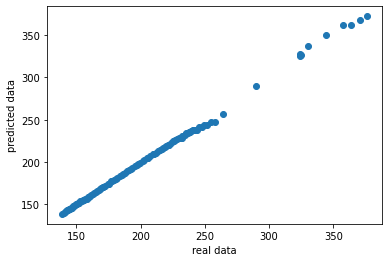

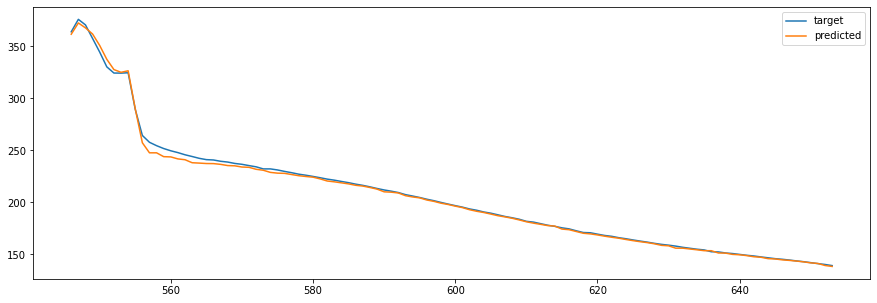

In [119]:

mae, res, plt = get_mae(model, data, 16)
datax = data.loc[data.diameter == 16].copy()
print(type(res))
datax['predicted'] = res
print(datax.head())
_ = datax[['target', 'predicted']].plot(figsize=(15, 5))


In [120]:
def tebak(d, datax, cycle):
  check = pd.DataFrame({'Cycle' : [2],'discharge_b':datax.iloc[0,2], 'diameter':[d]})
  for i in range(cycle-1):
    res = model.predict(check.tail(1))
    tmp = pd.DataFrame({'Cycle' : check.iloc[-1,0]+1,'discharge_b':res, 'diameter':[d]})
    check=check.append(tmp, ignore_index=True)  

  # datax['predicted'] = check['discharge_b']
  # print(datax.head())
  # mae = mean_absolute_error(datax['target'],datax['discharge_b'])
  # frame = datax[['target', 'predicted']].plot(figsize=(15, 5), title='Diameter' + str(d))
  return check

3.5578862595419847 AxesSubplot(0.125,0.125;0.775x0.755)
2.7703185185185184 AxesSubplot(0.125,0.125;0.775x0.755)
2.2571858974358965 AxesSubplot(0.125,0.125;0.775x0.755)
3.589158041958041 AxesSubplot(0.125,0.125;0.775x0.755)
2.7703185185185184 AxesSubplot(0.125,0.125;0.775x0.755)


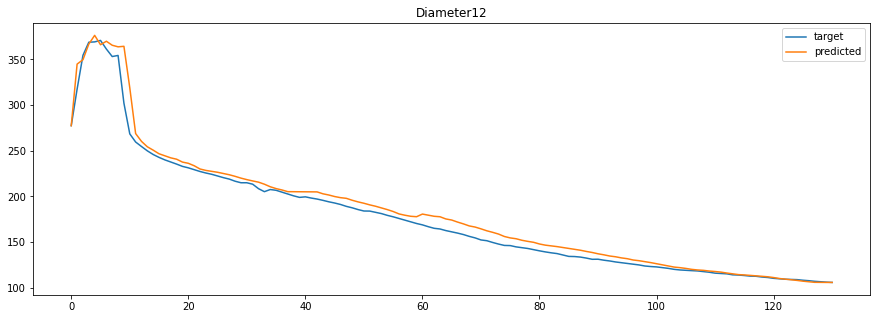

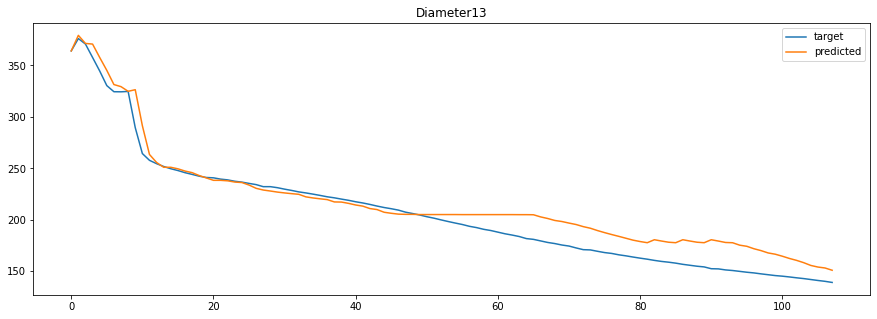

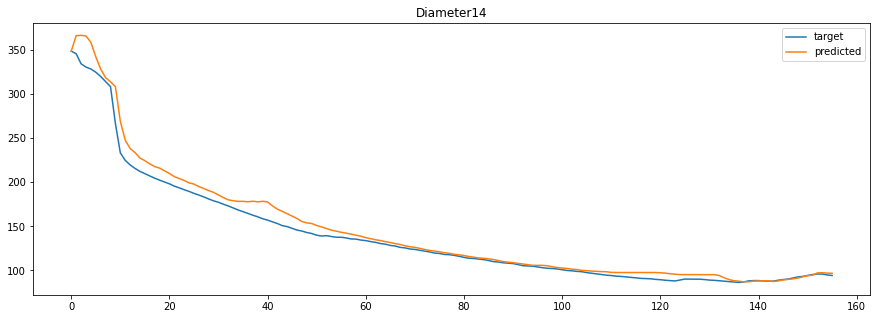

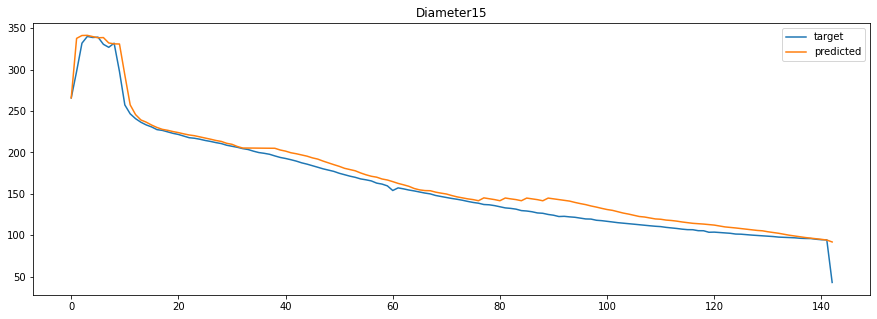

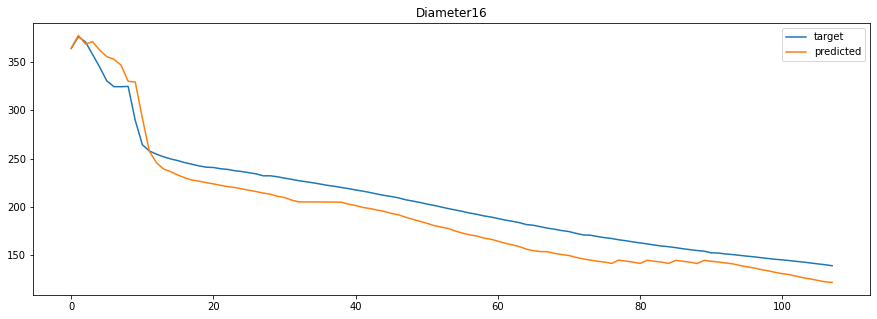

In [121]:
xxx = list()
test = [12,13,14,15,16]
for i in range(len(test)):
  datax = data.loc[data.diameter == test[i]].copy().reset_index()
  check = tebak(test[i],datax, datax.shape[0])
  datax['predicted'] = check['discharge_b']
  xxx.append((datax, test[i]))
  mae = mean_absolute_error(datax['target'],datax['discharge_b'])
  frame = datax[['target', 'predicted']].plot(figsize=(15, 5), title='Diameter' + str(test[i]))
  print(mae,frame)
  

AxesSubplot(0.125,0.125;0.775x0.755)
    Cycle  discharge_b  diameter
0       2   376.000000        17
1       3   374.826324        17
2       4   368.440704        17
3       5   370.802673        17
4       6   362.039032        17
..    ...          ...       ...
95     97   138.116562        17
96     98   136.882462        17
97     99   135.240997        17
98    100   133.893875        17
99    101   132.349228        17

[100 rows x 3 columns]


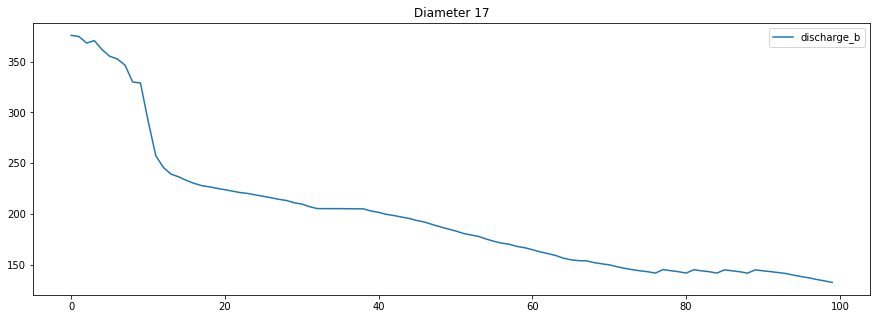

In [122]:
data17 = pd.DataFrame({'Cycle' : [2],'target':376,'discharge_b':376, 'diameter':[17]})
ans17 = tebak(17,data17, 100)
# print(ans17)
data17['predicted'] = ans17['discharge_b']
frame = ans17[['discharge_b']].plot(figsize=(15, 5), title='Diameter ' + str(17))
print(frame)
print(ans17)

In [123]:
data.head()

,Cycle,target,discharge_b,diameter
0,2,277.3889,177.8056,12
1,3,317.3194,277.3889,12
2,4,354.3333,317.3194,12
3,5,368.6806,354.3333,12
4,6,369.0556,368.6806,12


In [124]:
data2 = data.drop(labels=['Cycle'], axis = 1)
data_train1 = data2.loc[data.diameter < 16].copy()
data_test1 = data2.loc[data.diameter >= 16].copy()
data_test1.drop(labels=['target'], axis=1, inplace=True)
data_train1.drop(labels=['target'], axis=1, inplace=True)
data_train1.head()

,discharge_b,diameter
0,177.8056,12
1,277.3889,12
2,317.3194,12
3,354.3333,12
4,368.6806,12


In [125]:
model1 = XGBRegressor(n_estimators=3000, learning_rate=0.01)
model1.fit(data_train1, y_train)
y_predict1 = model1.predict(data_test1)
mae = mean_absolute_error(y_test, y_predict1)
print(mae)

[14:24:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6479485380949807


In [126]:
def tebak1(d, datax, cycle):
  check = pd.DataFrame({'discharge_b':datax.iloc[0,2], 'diameter':[d]})
  for i in range(cycle-1):
    res = model1.predict(check.tail(1))
    tmp = pd.DataFrame({'discharge_b':res, 'diameter':[d]})
    check=check.append(tmp, ignore_index=True)  

  # datax['predicted'] = check['discharge_b']
  # print(datax.head())
  # mae = mean_absolute_error(datax['target'],datax['discharge_b'])
  # frame = datax[['target', 'predicted']].plot(figsize=(15, 5), title='Diameter' + str(d))
  return check

3.5578862595419847 AxesSubplot(0.125,0.125;0.775x0.755)
2.7703185185185184 AxesSubplot(0.125,0.125;0.775x0.755)
2.2571858974358965 AxesSubplot(0.125,0.125;0.775x0.755)
3.589158041958041 AxesSubplot(0.125,0.125;0.775x0.755)
2.7703185185185184 AxesSubplot(0.125,0.125;0.775x0.755)


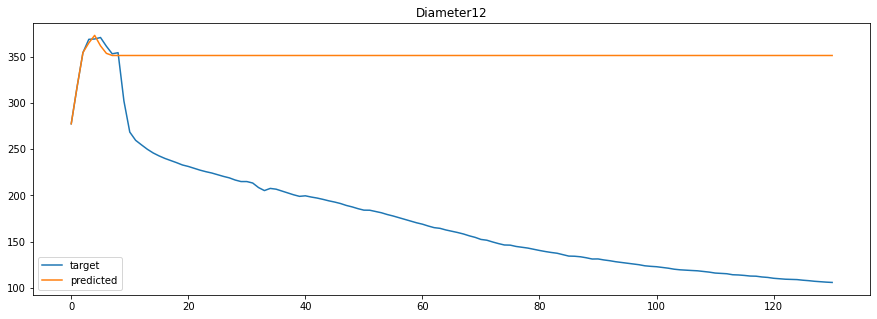

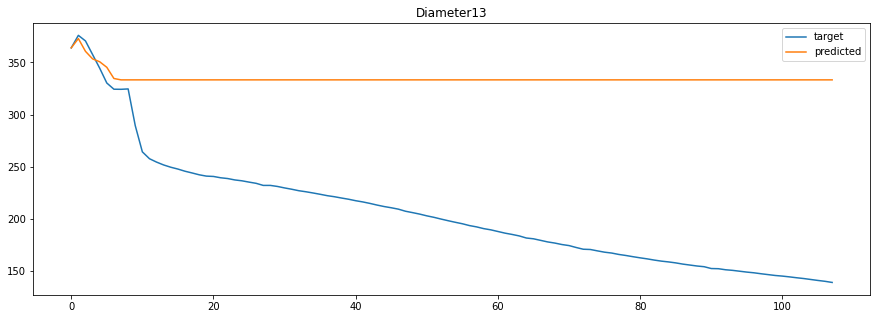

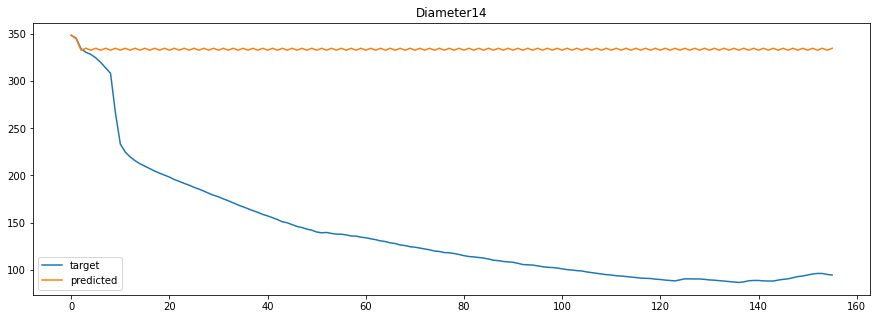

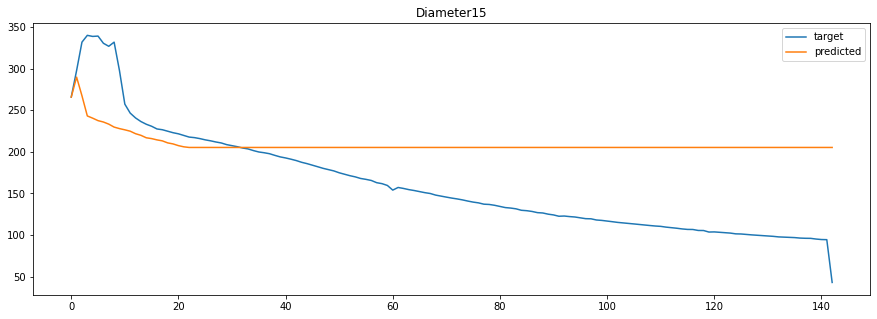

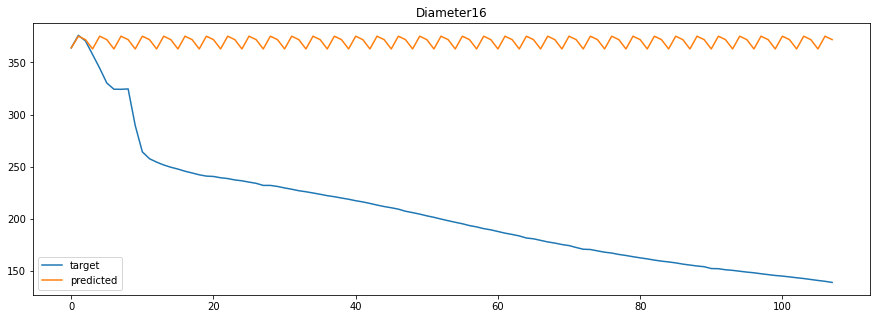

In [127]:
for i in range(len(test)):
  datax = data.loc[data.diameter == test[i]].copy().reset_index()
  check = tebak1(test[i],datax, datax.shape[0])
  datax['predicted'] = check['discharge_b']
  mae = mean_absolute_error(datax['target'],datax['discharge_b'])
  frame = datax[['target', 'predicted']].plot(figsize=(15, 5), title='Diameter' + str(test[i]))
  print(mae,frame)

    Cycle  discharge_b  diameter
0       2    91.430600        10
1       3   200.319595        10
2       4   284.773499        10
3       5   325.601868        10
4       6   342.862579        10
..    ...          ...       ...
95     97   131.820358        10
96     98   130.387100        10
97     99   129.628586        10
98    100   128.582703        10
99    101   127.540924        10

[100 rows x 3 columns] AxesSubplot(0.125,0.125;0.775x0.755)
    Cycle  discharge_b  diameter
0       2   321.916700        11
1       3   362.679260        11
2       4   382.403412        11
3       5   383.418762        11
4       6   371.571350        11
..    ...          ...       ...
95     97   131.820358        11
96     98   130.387100        11
97     99   129.628586        11
98    100   128.582703        11
99    101   127.540924        11

[100 rows x 3 columns] AxesSubplot(0.125,0.125;0.775x0.755)
    Cycle  discharge_b  diameter
0       2   376.625000        17
1       3   374.8263

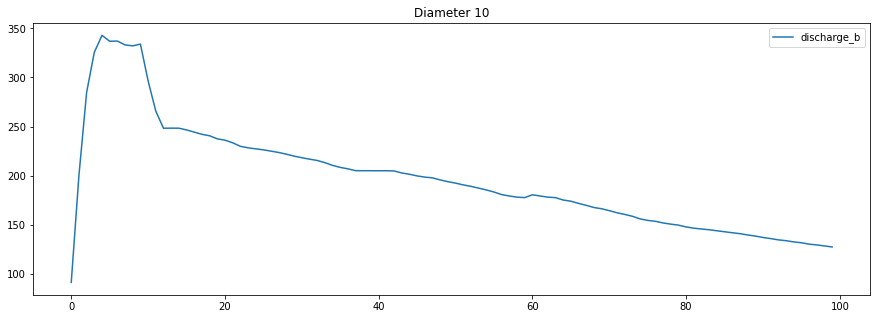

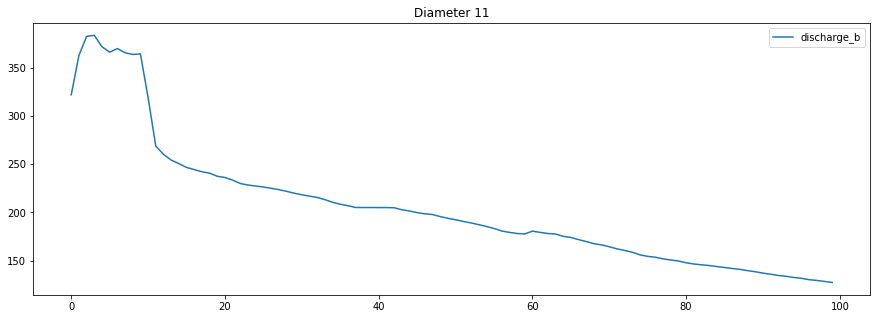

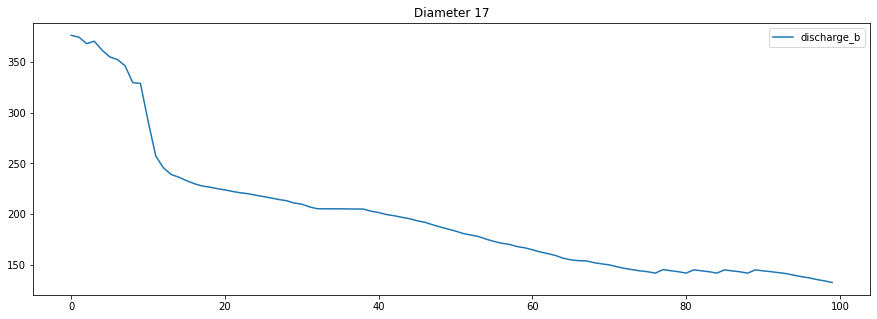

In [128]:
test2 = [(10, 91.4306), (11,321.9167), (17,376.625)]
result = []
for x in test2:
  datax = pd.DataFrame({'Cycle' : [2],'target':x[1],'discharge_b':x[1], 'diameter':x[0]})
  check = tebak(x[0], datax, 100)
  frame = check[['discharge_b']].plot(figsize=(15, 5), title='Diameter ' + str(x[0]))
  print(check, frame)
  result.append(check)

In [129]:
from google.colab import files
for i in range (len(result)):
  result[i].to_csv('data{}.csv'.format(i))

for i in range(len(xxx)):
  xxx[i][0].to_csv('data{}.csv'.format(xxx[i][1]))



Input data buat test, diameter 10 11 17

4.183124369747898 AxesSubplot(0.125,0.125;0.775x0.755)
2.5581036697247703 AxesSubplot(0.125,0.125;0.775x0.755)
2.3658880000000004 AxesSubplot(0.125,0.125;0.775x0.755)


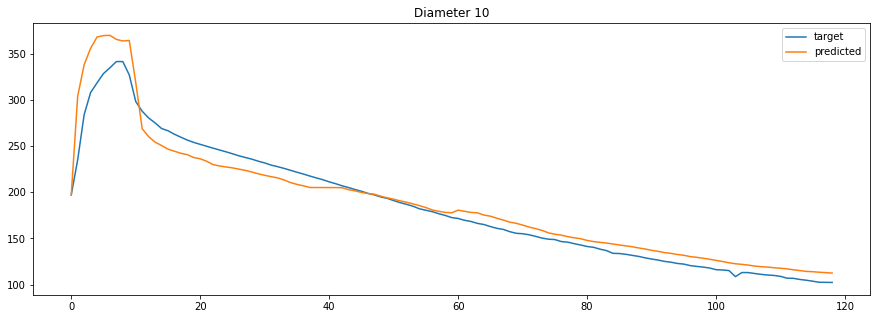

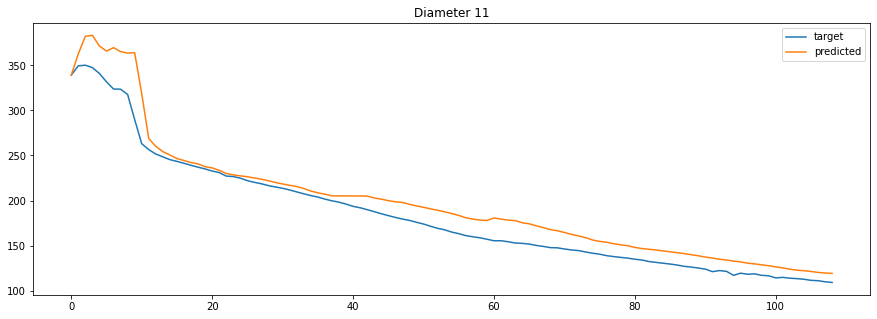

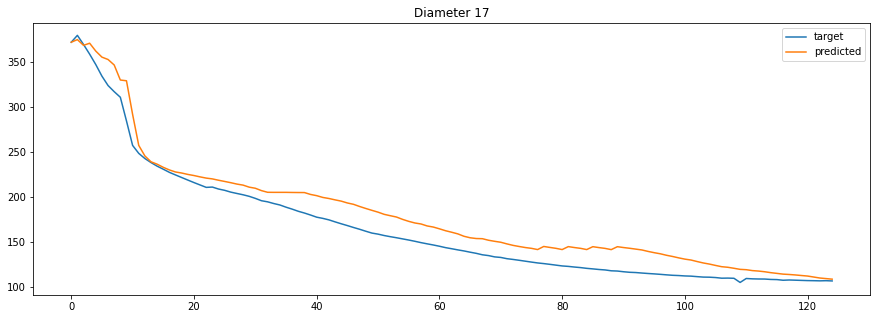

In [133]:
data2 = pd.read_csv("https://raw.githubusercontent.com/galacticor/learndatascience/master/mlforbattery/preproccess.xlsx%20-%20Test2.csv")
test2 = [10,11,17]
# print(data2.dtypes, data.head(), data2.head())
xdata = []
for i in range(len(test2)):
  datax = data2.loc[data2.diameter == test2[i]].copy().reset_index()
  check = tebak(test2[i],datax, datax.shape[0])
  datax['predicted'] = check['discharge_b']
  xdata.append((datax, test2[i]))
  mae = mean_absolute_error(datax['target'],datax['discharge_b'])
  frame = datax[['target', 'predicted']].plot(figsize=(15, 5), title='Diameter ' + str(test2[i]))
  print(mae,frame)